In [1]:
import warnings
warnings.filterwarnings("ignore")
from Server import *
from Graphing import *

c:\python36\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
earliest_patch = '9.11' # Earliest patch for dataset inclusion
perf_patch = '9.7'      # Earliest patch to analyse pro history for
n_max_missing = 2       # Maximum number of missing solo queue names for dataset inclusion
n_max_feats = 750       # Sequential feature selection options
n_min_feats = 1
# n_min_feats = 0.667
forward = True
floating = True
cv_k_folds = 5          # Cross validation options
cv_iter = 10
svm_C = 0.85            # SVM hyperparameters
svm_tol = 1e-5
n_pca_thresh = 99999    # Min. number of features to use PCA in feature selection (slow)

In [3]:
d, D, X_a, X, Y, X_groups, scalers, plist, llist, player_role_perfs, role_league_perf_cache = load_ld("pro_data")
selector = load_ld("pro_model_selector")

In [24]:
# Test accuracy of ZeroLossPCA vs normal PCA
n_splits = 20
n_repeats = 500
fset_index = 79

In [5]:
feat_is = selector.subsets_[fset_index]["feature_idx"]
X_f = np.hstack([X_a[i] for i in feat_is])

In [11]:
def test_comp_zero(X, Y, n_pca):
    m = ZeroLossPCA(SVC(gamma='auto', kernel='rbf', C=svm_C, tol=svm_tol), pca_n=n_pca)
    return cross_val_score(m, X, Y, cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats))
def test_comp_norm(X, Y, n_pca):
    m = Pipeline(steps=[
        ('pca', PCA(n_components=n_pca)),
        ('model', SVC(gamma='auto', kernel='rbf', C=svm_C, tol=svm_tol))
    ])
    return cross_val_score(m, X, Y, cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats))
pca_ns = list(range(1, min(X_f.shape[1], int(X_f.shape[0] * (1 - 1/n_splits)))))[::-1]
res_zero = Parallel(n_jobs=n_parallel_cpu, verbose=3)(delayed(test_comp_zero)(X_f, Y, n) for n in pca_ns)
res_norm = Parallel(n_jobs=n_parallel_cpu, verbose=3)(delayed(test_comp_norm)(X_f, Y, n) for n in pca_ns)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done  78 out of  78 | elapsed:  5.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   55.5s
[Parallel(n_jobs=8)]: Done  78 out of  78 | elapsed:  3.5min finished


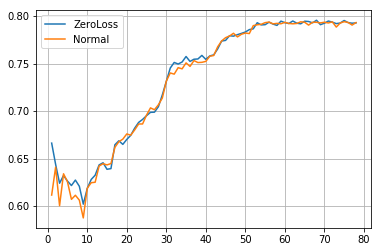

In [12]:
y_zero = [np.mean(y_) for y_ in res_zero]
y_norm = [np.mean(y_) for y_ in res_norm]
plt.plot(pca_ns, y_zero, label="ZeroLoss")
plt.plot(pca_ns, y_norm, label="Normal")
plt.legend()
plt.grid()

In [29]:
m = ZeroLossPCA(SVC(gamma='auto', kernel='rbf', C=svm_C, tol=svm_tol), pca_n=60)
a = cross_val_score(m, X_f, Y, cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats), n_jobs=n_parallel_cpu)
a.mean()

0.7937192307692307

In [7]:
# non-pca accuracy (fset 79): 0.792083916083916 (500 runs mean)
# 60c-pca accuracy (fset 79): 0.794235198135198 (500 runs mean)

(600,)

In [2]:
model_dict, model_strs, scales, n_train, n_test, n_pcal = load_ld(models_fn)
_, _, full_5_centers, full_5_scales, full_5_coefs = model_dict[(5, 5, 5, 5, 5, 5, 5)][6]
f5_x_ls = model_dict[(5, 5, 5, 5, 5, 5, 5)][0]
mkey = "LogisticRegression"
f5_center_, f5_scale_, f5_coef_ = full_5_centers[mkey], full_5_scales[mkey], full_5_coefs[mkey]

In [3]:
data = load_ld("pro_d")
len(data)

605

In [4]:
_ = load_global_stats()

 2019-08-06 22:23:49 Loading global champion & matchup stats databases...
 2019-08-06 22:24:25 Finished loading global champion & matchup stats databases!


In [5]:
# # First, filter out games with too many unknown solo queue names, or no solo queue data
# data = [d for d in data if d["meta"]["n_sqnames_missing"] < 1]
# print(len(data))
# data = [d for d in data if 'X' in d]
# print(len(data))

In [6]:
# Filter out games that were too long ago
# data = [d for d in data if d["meta"]["timestamp"] < n_weeks_ago(5, milliseconds=False)]
earliest_patch = '9.6'
patches_list = []
for i in range(len(patches_all)):
    patch = patches_all[i]
    patches_list.append(patch)
    if patch == earliest_patch:
        break
patches_list = patches_list[::-1]
patches_set = set(patches_list)
perf_earliest_patch = '9.6'
perf_patches_list = []
for i in range(len(patches_all)):
    patch = patches_all[i]
    perf_patches_list.append(patch)
    if patch == perf_earliest_patch:
        break
perf_patches_list = perf_patches_list[::-1]
perf_patches_set = set(perf_patches_list)
# print(len(data))

In [7]:
# Filter out game(s) with some missing features
contain_nan = [
    'visionwardbuys',
    'fbassist',
    'doubles',
    'triples',
    'csat10',
    'goldat10',
    'xpat10',
]
for l in contain_nan:
    data = [d for d in data if not any(np.isnan(pl[l]) if type(pl[l]) is np.float64 \
                            else pl[l] == ' ' or pl[l] is None for pl in d["players"])]
    print(len(data))

605
605
605
605
605
605
605


In [8]:
# Get list of unique players
pl_list = set()
for d in data:
    for p in d["players"]:
        pl_list.add(p["player"])
pl_list = list(pl_list)
len(pl_list)

337

In [9]:
# Create arrays to store gameid,player,role,league,patch_in_perfpatches,game_performance entries
pro_correspondence = deepcopy(pro_correspondence_ratios)
for l in pro_correspondence:
    key = pro_correspondence[l]
    pro_correspondence[l] = {
        role: (abs(f5_coef_['blue_'+role+'_'+key]) + abs(f5_coef_['red_'+role+'_'+key])) / 2
          for role in roles_all
    }
    pro_correspondence[l] = {
        role: {side: abs(f5_coef_[side + '_' + role + '_' + key]) / pro_correspondence[l][role]
          for side in cols_all} for role in roles_all
    }
pl_perfs_meta = np.zeros((len(data) * 10, 5))
n_perf_feats = len(pro_full_player_labels)
pl_perfs = np.zeros((len(data) * 10, n_perf_feats))
pl_perfs_i = 0
gid_list = [d["meta"]["gameid"] for d in data]
nans = 0
for d in data:
    gid = d['meta']['gameid']
    patch = d["meta"]["patch"]
    league = pro_leagues.index(d['meta']['league'])
    for i in range(10):
        pl = d["players"][i]
        r = pro_role_ord[i]
        role = r.split('_')[1]
        side = r.split('_')[0]
        opp_r = cols_all[1 - cols_all.index(side)] + '_' + role
        opp_pl = d["players"][pro_role_ord.index(opp_r)]
        opp_cid = opp_pl["champion"]
        name = pl["player"]
        cid = pl["champion"]
        team = d[side + "_team"]
        
        # Get global stats for the matchup
        ms = get_chgg_gms(patch_tss[patch] * 1000, cid, len(chgg_elos) - 1, role, opp_cid)
        
        pl_perfs_meta[pl_perfs_i] = [gid_list.index(gid), pl_list.index(name), roles_all.index(role), league,
                                     int(d["meta"]["patch"] in perf_patches_set)]
        pl_perfs[pl_perfs_i] = [float(pl[l]) for l in X_pro_player_labels] + \
                               [float(pl[l]) * pro_correspondence[l][role][side] for l in pro_correspondence] + \
            [float(pl[l]) / (ms['u'][pro_gms_ratios[l]] if ms['u'][pro_gms_ratios[l]] > 0 else 1.0) for l in pro_gms_ratios] + \
                               [np.nan_to_num(float(team[l])) for l in pro_team_player_labels]
#         if np.any(np.isnan(pl_perfs[pl_perfs_i])):
#             pr(pl_perfs[pl_perfs_i])
#             if i == 0:
#                 nans += 1
        
        pl_perfs_i += 1
pl_perfs_meta.shape, pl_perfs.shape, nans

 2019-08-06 22:24:26 Matchup champion 404: Qiyana middle 4 1561844201674
 2019-08-06 22:24:26 Matchup champion 404: Qiyana top 4 1561844201674
 2019-08-06 22:24:26 Matchup champion 404: Qiyana middle 4 1561844201674
 2019-08-06 22:24:26 Matchup champion 404: Qiyana middle 4 1561844201674
 2019-08-06 22:24:26 Matchup champion 404: Qiyana middle 4 1561844201674
 2019-08-06 22:24:26 Matchup champion 404: Qiyana middle 4 1561844201674
 2019-08-06 22:24:26 Matchup champion 404: Qiyana jungle 4 1561844201674
 2019-08-06 22:24:26 Matchup champion 404: Qiyana jungle 4 1561844201674
 2019-08-06 22:24:26 Matchup champion 404: Qiyana middle 4 1561844201674
 2019-08-06 22:24:26 Matchup champion 404: Qiyana middle 4 1561844201674
 2019-08-06 22:24:26 Matchup champion 404: Qiyana middle 4 1561844201674
 2019-08-06 22:24:26 Matchup champion 404: Qiyana middle 4 1561844201674
 2019-08-06 22:24:26 Matchup champion 404: Qiyana middle 4 1561844201674
 2019-08-06 22:24:26 Matchup champion 404: Qiyana midd

((6050, 5), (6050, 45), 0)

In [10]:
# Construct final data array - encode categoricals with index
leagues_list = deepcopy(pro_leagues)
sqo_labels = []
for d in data:
    if 'X' in d:
        X_ls = d["X"]["X_labels"]
        if len(X_ls) > len(sqo_labels):
            sqo_labels = X_ls
# sqo_labels = [l for l in sqo_labels if '_' in l]
sqo_labels = deepcopy(f5_x_ls)
print(len(sqo_labels))
f5_center = np.asarray([f5_center_[l] for l in sqo_labels])
f5_scale = np.asarray([f5_scale_[l] for l in sqo_labels])
f5_coef = np.asarray([f5_coef_[l] for l in sqo_labels])
sqo_pl_labels = ['_'.join(l.split('_')[2:]) for l in sqo_labels if l[:8] == "blue_top"]
sqo_bot_labels = ['_'.join(l.split('_')[1:]) for l in sqo_labels if l[:5] == "blue_" and l.split('_')[1] not in roles_all]
role_league_perf_cache = {}
for league_i in range(len(leagues_list)):
    for ri in range_5:
        onehot = np.all(pl_perfs_meta[:, [2,3]] == [ri, league_i], axis=1)
        role_league_perf_cache[str(ri) + '_' + str(league_i)] = np.mean(pl_perfs[np.nonzero(onehot)[0]], axis=0)
player_role_perfs = {}
D = []
for d in data:
    x = OrderedDict()
    x['gameid'] = d["meta"]["gameid"]
    x['blue_win'] = d["meta"]["blue_win"]
    x['league'] = leagues_list.index(d["meta"]["league"])
#     x['duration'] = d["meta"]["duration"]

    x['series_count'] = d["meta"]["series_count"]
    x['series_ingame_time'] = d["meta"]["series_ingame_time"]
    x['series_blue_wins'] = d["meta"]["series_blue_wins"]
    x['series_blue_winstreak'] = d["meta"]["series_blue_winstreak"]
    x['series_red_wins'] = d["meta"]["series_red_wins"]
    x['series_red_winstreak'] = d["meta"]["series_red_winstreak"]

    # Get player-role performances averages, excluding this game
    perfs = {}
    for i in range(10):
        pl = d["players"][i]
        r = pro_role_ord[i]
        
        gid_i = gid_list.index(d["meta"]["gameid"])
        name_i = pl_list.index(pl["player"])
        ri = roles_all.index(r.split('_')[1])
        league_i = x['league']
        
        onehot = np.logical_and(
            np.all(pl_perfs_meta[:, [1,2]] == [name_i, ri], axis=1),
            pl_perfs_meta[:, 0] != gid_i)
        res = None
        if sum(onehot) < 3:
            res = role_league_perf_cache[str(ri) + '_' + str(league_i)]
        else:
            res = np.mean(pl_perfs[np.nonzero(onehot)[0]], axis=0)
        perfs[r] = res
        
        pl_r_key = pl["player"] + '_' + str(ri)
        if pl_r_key not in player_role_perfs:
            onehot = np.all(pl_perfs_meta[:, [1,2,4]] == [name_i, ri, 1], axis=1)
            if sum(onehot) < 3:
                pass
#                 print("Less than 3 samples (", sum(onehot), ") for", pl["player"], roles_all[ri])
            else:
                player_role_perfs[pl_r_key] = np.mean(pl_perfs[np.nonzero(onehot)[0]], axis=0)
    x['performances'] = perfs
    
    if 'X' in d:
        # Get model output
        x['sq_prediction'] = d["X"]["sq_pred"]
        x_f = d['X']['X'][0]
        x_labels = d['X']['X_labels']
    #     print(len(x_f), len(x_labels))
        out = np.zeros(len(sqo_labels))
        for l_i in range(len(x_labels)):
            l = x_labels[l_i]
            if l in sqo_labels:
                sq_li = sqo_labels.index(l)
                out[sq_li] = ((x_f[l_i] - f5_center[sq_li]) / f5_scale[sq_li]) * f5_coef[sq_li]
        x["sq_output"] = out

    # Add to dataset if criteria are met
#     if 'X' in d and (("n_missing" in d["X"] and d["X"]["n_missing"] < 1) or \
#                      ("n_missing" not in d["X"] and d["meta"]["n_sqnames_missing"] < 1)) and d["meta"]["patch"] in patches_set:
    if 'X' in d and ("n_missing" in d["X"] and d["X"]["n_missing"] < 3):
        x['patch'] = patches_list.index(d["meta"]["patch"])
        D.append(x)
#         print(d["meta"]["patch"]) # Check the meta info of the data that makes it through the filter (ensure balance)
#         print(d["blue_team"]["team"])
#         print(d["red_team"]["team"])
print(len(D))

2218
229


In [11]:
# Create data arrays for fast indexing during feature selection model training
noncat_grps = [
    'series_count',
    'series_ingame_time',
    'sq_prediction',
]
series_wins_grp = [
    'series_blue_wins',
    'series_red_wins',
]
series_winstreak_grp = [
    'series_blue_winstreak',
    'series_red_winstreak',
]
series_grps = [
    "series_wins",
    "series_winstreak",
]
sqo_pl_r_labels = sum([[r + '_' + l for l in sqo_pl_labels] for r in roles_all], [])
X_pro_player_r_labels = sum([[r + '_' + l for l in pro_full_player_labels] for r in roles_all], [])
X_pro_player_t_labels = sum([[r + '_' + l for l in pro_full_player_labels] for r in t_roles], [])
grps_config = \
    sqo_pl_r_labels + sqo_bot_labels + X_pro_player_r_labels
#     sqo_pl_labels + sqo_bot_labels + X_pro_player_r_labels
#     ['diff_' + l for l in sqo_pl_r_labels] + \
#     sqo_bot_labels + ['diff_' + l for l in sqo_bot_labels] + \
#     X_pro_player_r_labels + ['diff_' + l for l in X_pro_player_r_labels]
#     sqo_pl_r_labels + ['diff_' + l for l in sqo_pl_r_labels] + \
X_groups = [
    "league",
    "patch",
] + noncat_grps + series_grps + grps_config
leagues_arr = np.zeros((len(D), len(leagues_list)))
patches_arr = np.zeros((len(D), len(patches_list)))
for i in range(len(D)):
    d = D[i]
    leagues_arr[i, d["league"]] = 1
    patches_arr[i, d["patch"]] = 1
X_arrs = [leagues_arr, patches_arr]
X_arrs += [np.asarray([d[l] for d in D]).reshape(-1, 1) for l in noncat_grps]

# Current configuration: take difference between sides, allow selection among roles (no grouping or summing)

# X_arrs += [np.asarray([[d[l] for l in series_wins_grp] for d in D])]
# X_arrs += [np.asarray([[d[l] for l in series_winstreak_grp] for d in D])]
X_arrs += [np.asarray([d["series_blue_wins"] - d["series_red_wins"] for d in D]).reshape(-1, 1)]
X_arrs += [np.asarray([d["series_blue_winstreak"] - d["series_red_winstreak"] for d in D]).reshape(-1, 1)]

# X_arrs += [np.asarray([[d["sq_output"][sqo_labels.index(r + '_' + l)] for r in t_roles] for d in D])
#        for l in sqo_pl_labels]                                                                  # raw, roles grouped
# X_arrs += sum([[np.asarray([[d["sq_output"][sqo_labels.index(c + '_' + r + '_' + l)] for c in cols_all] for d in D])
#        for l in sqo_pl_labels] for r in roles_all], [])                                           # raw, roles ungrouped
# X_arrs += [np.asarray([[d["sq_output"][sqo_labels.index('blue_' + r + '_' + l)] for r in roles_all] for d in D]) - \
#            np.asarray([[d["sq_output"][sqo_labels.index('red_' + r + '_' + l)] for r in roles_all] for d in D])
#         for l in sqo_pl_labels]                                                                 # diff, roles grouped
X_arrs += sum([[np.asarray([d["sq_output"][sqo_labels.index('blue_' + r + '_' + l)] for d in D]).reshape(-1, 1) - \
                np.asarray([d["sq_output"][sqo_labels.index('red_' + r + '_' + l)] for d in D]).reshape(-1, 1)
        for l in sqo_pl_labels] for r in roles_all], [])                                        # diff, roles ungrouped
# X_arrs += [np.sum([np.asarray([d["sq_output"][sqo_labels.index('blue_' + r + '_' + l)] for d in D]).reshape(-1, 1) - \
#                    np.asarray([d["sq_output"][sqo_labels.index('red_' + r + '_' + l)] for d in D]).reshape(-1, 1)
#         for r in roles_all], axis=0) for l in sqo_pl_labels]                                    # diff, roles summed

# X_arrs += [np.asarray([[d["sq_output"][sqo_labels.index(c + '_' + l)] for c in cols_all] for d in D]) for l in sqo_bot_labels]
X_arrs += [np.asarray([d["sq_output"][sqo_labels.index('blue_' + l)] for d in D]).reshape(-1, 1) - \
           np.asarray([d["sq_output"][sqo_labels.index('red_' + l)] for d in D]).reshape(-1, 1) for l in sqo_bot_labels]

# X_arrs += [np.asarray([[d["performances"][r][i] for r in t_roles] for d in D])
#         for i in range(n_perf_feats)]                                               # raw, roles grouped
# X_arrs += sum([[np.asarray([[d["performances"][c + '_' + r][i] for c in cols_all] for d in D])
#         for i in range(n_perf_feats)] for r in roles_all], [])                        # raw, roles ungrouped
# X_arrs += [np.asarray([[d["performances"]["blue_" + r][i] for r in roles_all] for d in D]) - \
#            np.asarray([[d["performances"]["red_" + r][i] for r in roles_all] for d in D])
#         for i in range(n_perf_feats)]                                               # diff, roles grouped
X_arrs += sum([[np.asarray([d["performances"]["blue_" + r][i] for d in D]).reshape(-1, 1) - \
                np.asarray([d["performances"]["red_" + r][i] for d in D]).reshape(-1, 1)
        for i in range(n_perf_feats)] for r in roles_all], [])                      # diff, roles ungrouped
# X_arrs += [np.sum([np.asarray([d["performances"]["blue_" + r][i] for d in D]).reshape(-1, 1) - \
#                    np.asarray([d["performances"]["red_" + r][i] for d in D]).reshape(-1, 1)
#         for r in roles_all], axis=0) for i in range(n_perf_feats)]                  # diff, roles summed

In [12]:
# Remove a random subset of data

# tried_is = [
#     138, 129,  54,   2,  66,  86,  99,  32
#     107,  59,  70, 103, 123,   0,  76,  95
#      32,  48,  42, 143,  70, 131,  34,  90
#       0,   3,  79,  26,  53, 122, 113, 110
#     118,  42,  52,  30,  16,  72,  70, 100
#       8, 107,  48,  18,  53, 102,  78, 140
# ]

n_data = X_arrs[0].shape[0]
# rem_is = np.random.choice(list(set(range(n_data)) - set(tried_is)), 8, False)
# rem_is = np.random.choice(n_data, 8, False)
# rem_is = [107, 78, 140, 138, 129]
rem_is = []
inds = [j for j in range(n_data) if j not in rem_is]
X_a = [X_arr[inds] for X_arr in X_arrs]

# Apply robust scaling for appropriate feature groups
scale_groups = noncat_grps + series_grps + grps_config
scalers = {}
for l in scale_groups:
    l_i = X_groups.index(l)
    scaler = RobustScaler()
    X_a[l_i] = scaler.fit_transform(X_a[l_i])
    scalers[l] = scaler

# Create final X index representation
X = np.tile(range(len(inds)), (len(X_groups), 1)).T.astype(float)
for j in range(len(X_groups)):
    X[:, j] += j / 10000

Y = np.asarray([d["blue_win"] for d in D])[inds]
X.shape, Y.shape, len(X_a), len(X_groups), sum([arr.shape[1] for arr in X_a]), X_a[0].shape

((229, 1341), (229,), 1341, 1341, 1354, (229, 6))

In [13]:
# Test accuracy with all features
m = SVC(gamma='auto', kernel='rbf', C=0.94, tol=1e-4)
# m = LinearSVC(loss='squared_hinge', penalty='l1', dual=False, C=0.78)
m = FoldingWrapper(m, X_a, pca=None)
# scores = np.hstack([cross_val_score(m, X, Y, cv=StratifiedShuffleSplit(n_splits=20)) for _ in range(10)])
scores = cross_val_score(m, X, Y, cv=LeaveOneOut())
fscore = np.mean(scores)
fscore

0.5545851528384279

In [12]:
# Feature selection (with PCA above n components)
# m = LinearSVC()
# m = LogisticRegression()
# m = DecisionTreeClassifier()
m = SVC(gamma='auto', kernel='rbf', C=0.94, tol=1e-4)
# m = LinearSVC(loss='squared_hinge', penalty='l1', dual=False, C=100)
# m = GaussianProcessClassifier(n_restarts_optimizer=5)
m = FoldingWrapper(m, X_a, pca=20)

selector = SFS(k_features=(1, len(X_groups)), forward=True, floating=True,
               cv=(20, StratifiedShuffleSplit(n_splits=20)),
               estimator=m, n_jobs=8, verbose=5)
X_selected = selector.fit_transform(X, Y)
# X_selected = selector.transform(X_scaled)
scores = cross_val_score(m, X_selected, Y, cv=LeaveOneOut())
np.mean(scores)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   34.6s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  4.5min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:  6.6min
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed: 12.1min
[Parallel(n_jobs=8)]: Done 1341 out of 1341 | elapsed: 14.7min finished

[2019-07-30 01:06:03] Features: 1/1341 -- score: 0.6701923076923078[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    5.6s

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

0.6771653543307087

In [41]:
[(i, selector.subsets_[i]['avg_score']) for i in range(1, len(selector.subsets_) + 1)]

[(1, 0.67734375),
 (2, 0.7171875),
 (3, 0.74546875),
 (4, 0.7628125),
 (5, 0.78375),
 (6, 0.7871875),
 (7, 0.8003125),
 (8, 0.81625),
 (9, 0.82703125),
 (10, 0.825),
 (11, 0.83140625),
 (12, 0.8328125),
 (13, 0.83921875),
 (14, 0.84),
 (15, 0.84375),
 (16, 0.8415625),
 (17, 0.84734375),
 (18, 0.8453125),
 (19, 0.84984375),
 (20, 0.8540625),
 (21, 0.858125),
 (22, 0.8590625),
 (23, 0.86),
 (24, 0.86015625),
 (25, 0.85765625),
 (26, 0.85453125),
 (27, 0.8525),
 (28, 0.84828125),
 (29, 0.84859375),
 (30, 0.849375),
 (31, 0.84875),
 (32, 0.84625),
 (33, 0.84984375),
 (34, 0.8528125),
 (35, 0.85171875),
 (36, 0.85109375),
 (37, 0.84703125),
 (38, 0.85640625),
 (39, 0.84828125)]

In [16]:
[(i, selector.subsets_[i]['avg_score']) for i in range(1, len(selector.subsets_) + 1)]

[(1, 0.685),
 (2, 0.726),
 (3, 0.77775),
 (4, 0.79625),
 (5, 0.823),
 (6, 0.8385000000000001),
 (7, 0.8630000000000001),
 (8, 0.8605000000000002),
 (9, 0.8682500000000001),
 (10, 0.8630000000000001),
 (11, 0.86275),
 (12, 0.8762500000000002),
 (13, 0.8835000000000001),
 (14, 0.8952500000000002),
 (15, 0.9030000000000001),
 (16, 0.8955000000000001),
 (17, 0.9355000000000001),
 (18, 0.9420000000000002),
 (19, 0.9425),
 (20, 0.9480000000000001),
 (21, 0.9484999999999999),
 (22, 0.9485000000000001),
 (23, 0.9477500000000001),
 (24, 0.9435000000000001),
 (25, 0.9440000000000001),
 (26, 0.9432500000000001),
 (27, 0.9495000000000001),
 (28, 0.9507500000000002),
 (29, 0.94875),
 (30, 0.94875),
 (31, 0.9470000000000002),
 (32, 0.94725),
 (33, 0.9470000000000001),
 (34, 0.9442500000000001),
 (35, 0.9417500000000001),
 (36, 0.9440000000000001),
 (37, 0.9492499999999999),
 (38, 0.9480000000000001),
 (39, 0.94525),
 (40, 0.94225),
 (41, 0.9437500000000001),
 (42, 0.9375),
 (43, 0.9312500000000001)]

In [38]:
# feat_is = selector.subsets_[54]["feature_idx"]
feat_is = selector.k_feature_idx_
[X_groups[i] for i in feat_is], len(feat_is)

(['top_chgg_eloavg_champion_total_heal',
  'top_opgg_champion_all_Tank_losses',
  'top_opgg_champion_avg_gold',
  'top_8ravg_pinks_purchased_/_chgg_eloavg_champion_wards_killed',
  'jungle_4ravg_pinks_purchased_/_chgg_eloavg_champion_wards_placed',
  'jungle_8ravg_pinks_purchased_/_chgg_eloavg_champion_wards_placed',
  'middle_4ravg_creep_score_/_opgg_champion_recent_creep_score',
  'middle_8ravg_pinks_purchased',
  'support_chgg_eloavg_champion_duration_15_to_20_win_rate',
  'support_2ravg_assists_/_opgg_champion_recent_assists',
  'support_8ravg_pinks_purchased',
  'support_8ravg_creep_score_/_opgg_eloavg_champion_today_creep_score',
  'support_opgg_champion_recent_creep_score_/_opgg_eloavg_champion_today_creep_score',
  'support_opgg_champion_recent_creep_score',
  'adc_chgg_eloavg_champion_kill_sprees',
  'adc_chgg_eloavg_champion_duration_0_to_15_win_rate',
  'adc_chgg_eloavg_champion_duration_15_to_20_win_rate',
  'top_minionkills',
  'top_dmgtochamps',
  'top_csat10',
  'top_tot

In [52]:
m = SVC(gamma='auto', kernel='rbf', C=0.94, tol=1e-4)
m = FoldingWrapper(m, X_a, pca=20)
X_selected = X[:, feat_is]
# scores = cross_val_score(m, X_selected, Y, cv=StratifiedShuffleSplit(n_splits=20))
scores = cross_val_score(m, X_selected, Y, cv=LeaveOneOut())
fscore = np.mean(scores)
fscore

0.875

In [51]:
# Train and save final model and all infill data
m = SVC(gamma='auto', kernel='rbf', C=0.94, tol=1e-4, probability=True)
m = Pipeline(steps=[
    ("pca", PCA(n_components=20)),
    ("model", m),
])
X_f = np.hstack([X_a[i] for i in feat_is])
m.fit(X_f, Y)
X_flabels = [X_groups[i] for i in feat_is]
fscalers = [scalers[l] for l in X_flabels]
save_ld(((m, X_flabels, fscalers, patches_list, leagues_list, player_role_perfs, role_league_perf_cache), fscore), "pro_model")

In [ ]:
# Solo-queue data only prediction

In [14]:
X_sq = X[:, [i for i in range(X.shape[1]) if '_'.join(X_groups[i].split('_')[1:]) not in pro_full_player_labels]]
X_sq.shape

(173, 1116)

In [15]:
sqlabels = [l for l in X_groups if '_'.join(l.split('_')[1:]) not in pro_full_player_labels]
len(sqlabels)

1116

In [16]:
# Solo-queue only feature selection (with PCA above n components)
# m = LinearSVC()
# m = LogisticRegression()
# m = DecisionTreeClassifier()
m = SVC(gamma='auto', kernel='rbf', C=0.94, tol=1e-4)
# m = LinearSVC(loss='squared_hinge', penalty='l1', dual=False, C=100)
# m = GaussianProcessClassifier(n_restarts_optimizer=5)
m = FoldingWrapper(m, X_a, pca=20)

selector = SFS(k_features=(1, X_sq.shape[1]), forward=True, floating=True,
               cv=(20, StratifiedShuffleSplit(n_splits=20)),
               estimator=m, n_jobs=8, verbose=5)
X_sq_selected = selector.fit_transform(X_sq, Y)
# X_selected = selector.transform(X_scaled)
scores = cross_val_score(m, X_sq_selected, Y, cv=LeaveOneOut())
np.mean(scores)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    7.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   49.6s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  6.7min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:  9.5min
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed: 12.8min
[Parallel(n_jobs=8)]: Done 1116 out of 1116 | elapsed: 16.7min finished

[2019-07-30 05:07:32] Features: 1/1116 -- score: 0.6461111111111112[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   45.3s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 434 tasks   

[Parallel(n_jobs=8)]: Done 1107 out of 1107 | elapsed: 16.5min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    7.0s remaining:   24.7s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    8.8s remaining:   11.1s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    9.0s remaining:    4.4s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:   11.7s finished

[2019-07-30 07:36:31] Features: 10/1116 -- score: 0.7994444444444446[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    7.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   56.9s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  4.1min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:  9.4min
[Parallel(n_jobs=8)]: Done 866 ta

[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:   11.6s remaining:    3.8s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:   12.8s finished

[2019-07-30 09:18:32] Features: 13/1116 -- score: 0.8013888888888888[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   58.5s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  6.7min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:  9.8min
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed: 13.3min
[Parallel(n_jobs=8)]: Done 1103 out of 1103 | elapsed: 16.9min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:

[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  7.8min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed: 11.5min
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed: 15.9min
[Parallel(n_jobs=8)]: Done 1096 out of 1096 | elapsed: 19.8min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done  10 out of  20 | elapsed:   12.1s remaining:   12.1s
[Parallel(n_jobs=8)]: Done  15 out of  20 | elapsed:   17.0s remaining:    5.6s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:   21.0s finished

[2019-07-30 11:33:24] Features: 21/1116 -- score: 0.7947222222222223[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   59.3s
[Parallel(n_jobs=8)]: Done 146 ta

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  4.3min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  6.8min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed: 10.0min
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed: 13.9min
[Parallel(n_jobs=8)]: Done 1094 out of 1094 | elapsed: 17.9min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done  12 out of  22 | elapsed:   20.4s remaining:   17.0s
[Parallel(n_jobs=8)]: Done  17 out of  22 | elapsed:   21.5s remaining:    6.2s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:   28.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  22 out of  22 | elapsed:   28.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    8.1s
[Parallel(n_jobs=8)]: Done  11 out of  21

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   49.8s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  5.9min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:  8.6min
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed: 11.8min
[Parallel(n_jobs=8)]: Done 1089 out of 1089 | elapsed: 14.8min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    6.1s
[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:   18.4s remaining:    9.2s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:   24.2s remaining:    2.9s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:   24.8s finished

[2019-07-30 15:22:59] Features: 28/1116 -- score: 0.8373611111111111[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent 

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done  28 out of  35 | elapsed:   30.3s remaining:    7.5s
[Parallel(n_jobs=8)]: Done  35 out of  35 | elapsed:   36.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done  26 out of  34 | elapsed:   28.8s remaining:    8.8s
[Parallel(n_jobs=8)]: Done  34 out of  34 | elapsed:   34.1s finished

[2019-07-30 17:37:08] Features: 35/1116 -- score: 0.8305555555555557[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    7.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   54.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  6.6min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:  

BrokenProcessPool: A task has failed to un-serialize while the future was running or pending.

In [17]:
sqfeat_is = [X_groups.index(sqlabels[i]) for i in selector.k_feature_idx_]

TypeError: 'NoneType' object is not iterable

In [50]:
m = SVC(gamma='auto', kernel='rbf', C=0.94, tol=1e-4)
m = FoldingWrapper(m, X_a, pca=20)
X_selected = X[:, sqfeat_is]
# scores = cross_val_score(m, X_selected, Y, cv=StratifiedShuffleSplit(n_splits=20))
scores = cross_val_score(m, X_selected, Y, cv=LeaveOneOut())
fscore = np.mean(scores)
fscore

0.8251121076233184

In [51]:
# Train and save final model and all infill data
m = SVC(gamma='auto', kernel='rbf', C=0.94, tol=1e-4, probability=True)
# m = Pipeline(steps=[
#     ("pca", PCA(n_components=50)),
#     ("model", m),
# ])
X_f = np.hstack([X_a[i] for i in sqfeat_is])
m.fit(X_f, Y)
X_flabels = [X_groups[i] for i in sqfeat_is]
fscalers = [scalers[l] for l in X_flabels]
save_ld(((m,X_flabels,fscalers,patches_list,leagues_list,player_role_perfs,role_league_perf_cache),fscore), "pro_model_sqo")

In [ ]:
# Solo-queue pre-champ-select data only prediction

In [21]:
sqpc_labels = [l for l in X_groups if '_'.join(l.split('_')[1:]) not in pro_full_player_labels and \
               "_opgg_champion_recent" not in l and "_eloavg_" not in l]
X_sqpc = X[:, [i for i in range(X.shape[1]) if X_groups[i] in sqpc_labels]]
len(sqpc_labels), X_sqpc.shape

(377, (238, 377))

In [26]:
# Solo-queue pre-champ-select only feature selection (with PCA above n components)
# m = LinearSVC()
# m = LogisticRegression()
# m = DecisionTreeClassifier()
m = SVC(gamma='auto', kernel='rbf', C=0.94, tol=1e-4)
# m = LinearSVC(loss='squared_hinge', penalty='l1', dual=False, C=100)
# m = GaussianProcessClassifier(n_restarts_optimizer=5)
m = FoldingWrapper(m, X_a, pca=20)

selector = SFS(k_features=(1, X_sqpc.shape[1]), forward=True, floating=True,
               cv=(20, StratifiedShuffleSplit(n_splits=20)),
               estimator=m, n_jobs=8, verbose=5)
X_sqpc_selected = selector.fit_transform(X_sqpc, Y)
# X_selected = selector.transform(X_scaled)
scores = cross_val_score(m, X_sqpc_selected, Y, cv=LeaveOneOut())
np.mean(scores)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    7.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   49.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  3.9min
[Parallel(n_jobs=8)]: Done 377 out of 377 | elapsed:  5.4min finished

[2019-07-18 01:11:07] Features: 1/377 -- score: 0.6501041666666666[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   49.3s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 376 out of 376 | elapsed:  5.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.8s finished

[2019-07-

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   13.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  3.5min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  7.0min
[Parallel(n_jobs=8)]: Done 367 out of 367 | elapsed:  9.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:   10.5s remaining:   15.8s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   14.3s remaining:    6.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   16.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    9.5s remaining:   33.4s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:   11.4s remaining:   14.3s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:   12.2s remai

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 366 out of 366 | elapsed:  4.9min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of  11 | elapsed:    6.0s remaining:   27.5s
[Parallel(n_jobs=8)]: Done   5 out of  11 | elapsed:    6.4s remaining:    7.7s
[Parallel(n_jobs=8)]: Done   8 out of  11 | elapsed:    6.6s remaining:    2.4s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    9.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    6.1s remaining:    9.3s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    6.2s remaining:    2.6s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   46.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 361 out of 361 | elapsed:  4.8min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    6.4s remaining:   14.1s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:   12.1s remaining:    9.4s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:   12.5s remaining:    2.8s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:   12.7s finished

[2019-07-18 16:55:47] Features: 17/377 -- score: 0.7067708333333332[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   46.7s
[Parallel(n_jobs=8)]: Done 146 tasks

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   52.3s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  4.1min
[Parallel(n_jobs=8)]: Done 353 out of 353 | elapsed:  5.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:   14.5s remaining:   10.3s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:   21.3s remaining:    5.5s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:   21.7s finished

[2019-07-18 17:44:46] Features: 25/377 -- score: 0.7221875[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    7.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | e

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  3.9min
[Parallel(n_jobs=8)]: Done 346 out of 346 | elapsed:  4.9min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done  23 out of  31 | elapsed:   21.2s remaining:    7.3s
[Parallel(n_jobs=8)]: Done  31 out of  31 | elapsed:   26.7s finished

[2019-07-18 18:37:56] Features: 32/377 -- score: 0.7209375[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    7.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   51.9s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  3.9min
[Parallel(n_jobs=8)]: Done 345 out of 345 | elapsed:  4.9min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  5.7min
[Parallel(n_jobs=8)]: Done 339 out of 339 | elapsed:  7.0min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    9.5s
[Parallel(n_jobs=8)]: Done  31 out of  38 | elapsed:   40.0s remaining:    8.9s
[Parallel(n_jobs=8)]: Done  38 out of  38 | elapsed:   46.7s finished

[2019-07-18 19:52:16] Features: 39/377 -- score: 0.7288541666666666[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    9.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  6.4min
[Parallel(n_jobs=8)]: Done 338 out of 338 | elapsed:  7.8min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  7.5min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed: 11.9min
[Parallel(n_jobs=8)]: Done 329 out of 329 | elapsed: 13.9min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   16.0s
[Parallel(n_jobs=8)]: Done  43 out of  48 | elapsed:  1.6min remaining:   11.2s
[Parallel(n_jobs=8)]: Done  48 out of  48 | elapsed:  1.7min finished

[2019-07-18 22:20:37] Features: 49/377 -- score: 0.7577083333333333[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   16.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  5.3min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  9.8min
[Parallel(n_j

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   13.2s
[Parallel(n_jobs=8)]: Done  53 out of  56 | elapsed:  1.7min remaining:    5.6s
[Parallel(n_jobs=8)]: Done  56 out of  56 | elapsed:  1.7min finished

[2019-07-19 00:18:03] Features: 57/377 -- score: 0.74625[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   15.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  4.8min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  8.6min
[Parallel(n_jobs=8)]: Done 320 out of 320 | elapsed:  9.9min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   13.8s
[Parallel(n_jobs=8)]: Done  54 out of  57 | elapsed:  1.6min remaining:    5.3s
[Parallel(n_jobs=8)]: Done  57 out of  57 | elapsed:  1.7min finished

[2019-07-19 00:29:38] Features: 58/377 -- score: 0.74395

[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  4.6min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  8.6min
[Parallel(n_jobs=8)]: Done 315 out of 315 | elapsed:  9.9min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   14.3s
[Parallel(n_jobs=8)]: Done  60 out of  62 | elapsed:  1.9min remaining:    3.7s
[Parallel(n_jobs=8)]: Done  62 out of  62 | elapsed:  1.9min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   15.3s
[Parallel(n_jobs=8)]: Done  59 out of  61 | elapsed:  2.0min remaining:    4.0s
[Parallel(n_jobs=8)]: Done  61 out of  61 | elapsed:  2.1min finished

[2019-07-19 02:25:13] Features: 62/377 -- score: 0.7458333333333335[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 t

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  4.6min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  8.5min
[Parallel(n_jobs=8)]: Done 306 out of 306 | elapsed:  9.5min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   14.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done  71 out of  71 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done  71 out of  71 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   13.5s
[Parallel(n_jobs=8)]: Done  70 out of  70 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=8)]: Done  70 out of  70 | elapsed:  2.1min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   13.9s
[Parallel(n_jobs=8)]: Done  69 out of  

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   15.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  4.9min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:  9.9min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   15.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done  77 out of  77 | elapsed:  2.5min finished

[2019-07-19 06:56:53] Features: 78/377 -- score: 0.749375[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   16.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  5.0min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  9.2min
[Parallel(n_jobs=8)]: Done 299 out of 299 

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   23.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  3.5min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  8.5min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed: 15.5min
[Parallel(n_jobs=8)]: Done 291 out of 291 | elapsed: 16.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   26.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done  86 out of  86 | elapsed:  4.4min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   20.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done  85 out of  85 | elapsed:  4.0min finished

[2019-07-19 09:40:29] Features: 86/377 -- score: 0.7467708333333333[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel

0.7647058823529411

In [27]:
sqpcfeat_is = [X_groups.index(sqpc_labels[i]) for i in selector.k_feature_idx_]

In [28]:
m = SVC(gamma='auto', kernel='rbf', C=0.94, tol=1e-4)
m = FoldingWrapper(m, X_a, pca=20)
X_selected = X[:, sqpcfeat_is]
# scores = cross_val_score(m, X_selected, Y, cv=StratifiedShuffleSplit(n_splits=20))
scores = cross_val_score(m, X_selected, Y, cv=LeaveOneOut())
fscore = np.mean(scores)
fscore

0.7647058823529411

In [29]:
# Train and save final model and all infill data
m = SVC(gamma='auto', kernel='rbf', C=0.94, tol=1e-4, probability=True)
# m = Pipeline(steps=[
#     ("pca", PCA(n_components=50)),
#     ("model", m),
# ])
X_f = np.hstack([X_a[i] for i in sqpcfeat_is])
m.fit(X_f, Y)
X_flabels = [X_groups[i] for i in sqpcfeat_is]
fscalers = [scalers[l] for l in X_flabels]
save_ld(((m,X_flabels,fscalers,patches_list,leagues_list,player_role_perfs,role_league_perf_cache),fscore), "pro_model_sqpco")

In [ ]:
# Pro pre-champ-select data only prediction

In [32]:
ppc_labels = [l for l in X_groups if '_'.join(l.split('_')[1:]) in pro_full_player_labels or \
               ("_opgg_champion_recent" not in l and "_eloavg_" not in l)]
X_ppc = X[:, [i for i in range(X.shape[1]) if X_groups[i] in ppc_labels]]
len(ppc_labels), X_ppc.shape

(602, (238, 602))

In [33]:
# Pro pre-champ-select data only feature selection (with PCA above n components)
# m = LinearSVC()
# m = LogisticRegression()
# m = DecisionTreeClassifier()
m = SVC(gamma='auto', kernel='rbf', C=0.94, tol=1e-4)
# m = LinearSVC(loss='squared_hinge', penalty='l1', dual=False, C=100)
# m = GaussianProcessClassifier(n_restarts_optimizer=5)
m = FoldingWrapper(m, X_a, pca=20)

selector = SFS(k_features=(1, X_ppc.shape[1]), forward=True, floating=True,
               cv=(20, StratifiedShuffleSplit(n_splits=20)),
               estimator=m, n_jobs=8, verbose=5)
X_ppc_selected = selector.fit_transform(X_ppc, Y)
# X_selected = selector.transform(X_scaled)
scores = cross_val_score(m, X_ppc_selected, Y, cv=LeaveOneOut())
np.mean(scores)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    7.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   48.8s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  3.6min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  6.1min
[Parallel(n_jobs=8)]: Done 602 out of 602 | elapsed:  8.4min finished

[2019-07-19 11:23:31] Features: 1/602 -- score: 0.67[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   46.5s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  3.6min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  5.8min
[Parallel(n_jobs=8)]: Done 601 out of 601 | elapsed:  8.0min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    7.0s remaining:   11.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.0s remaining:    4.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.3s finished

[2019-07-19 12:56:50] Features: 9/602 -- score: 0.7258333333333333[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    8.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  4.5min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  7.2min
[Parallel(n_jobs=8)]: Done 593 out of 593 | elapsed:  9.5min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    6.5s remaining:   22.9s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    6.7s remaining:    8.4s
[Parallel(n_jobs=8

[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:   16.0s remaining:    3.9s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:   16.1s finished

[2019-07-19 14:11:52] Features: 16/602 -- score: 0.7358333333333335[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    8.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  4.7min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  7.4min
[Parallel(n_jobs=8)]: Done 586 out of 586 | elapsed:  9.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    7.5s remaining:   16.6s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:   13.2s remaining:   10.2s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:   14.4s remaining:    3.3s
[Parallel(n_jobs=

[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:   14.6s finished

[2019-07-19 15:14:34] Features: 19/602 -- score: 0.7536458333333335[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   42.9s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  5.5min
[Parallel(n_jobs=8)]: Done 583 out of 583 | elapsed:  7.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    6.4s remaining:    8.8s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:   11.8s remaining:    6.8s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:   12.1s remaining:    2.2s
[Parallel(n_jobs=8)]: Done  19 out o

[Parallel(n_jobs=8)]: Done  18 out of  27 | elapsed:   19.5s remaining:    9.7s
[Parallel(n_jobs=8)]: Done  24 out of  27 | elapsed:   20.1s remaining:    2.4s
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:   23.5s finished

[2019-07-19 16:27:57] Features: 28/602 -- score: 0.7802083333333333[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   47.4s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  6.0min
[Parallel(n_jobs=8)]: Done 574 out of 574 | elapsed:  7.9min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:   19.5s remaining:    9.2s
[Parallel(n_jobs=8)]: Done  25 out o

[Parallel(n_jobs=8)]: Done  34 out of  34 | elapsed:   30.9s finished

[2019-07-19 17:45:58] Features: 35/602 -- score: 0.7692708333333335[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    7.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   56.2s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  4.5min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 567 out of 567 | elapsed:  9.5min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    7.5s
[Parallel(n_jobs=8)]: Done  28 out of  35 | elapsed:   31.3s remaining:    7.7s
[Parallel(n_jobs=8)]: Done  35 out of  35 | elapsed:   35.3s finished

[2019-07-19 17:56:01] Features: 36/602 -- score: 0.7653125[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent w

[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  9.4min
[Parallel(n_jobs=8)]: Done 560 out of 560 | elapsed: 12.0min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    9.4s
[Parallel(n_jobs=8)]: Done  36 out of  42 | elapsed:   49.0s remaining:    8.1s
[Parallel(n_jobs=8)]: Done  42 out of  42 | elapsed:   53.3s finished

[2019-07-19 19:54:44] Features: 43/602 -- score: 0.7871875[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    9.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  5.8min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  9.2min
[Parallel(n_jobs=8)]: Done 559 out of 559 | elapsed: 11.7min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  3.6min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  6.6min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 10.4min
[Parallel(n_jobs=8)]: Done 555 out of 555 | elapsed: 13.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   12.7s
[Parallel(n_jobs=8)]: Done  42 out of  47 | elapsed:  1.1min remaining:    7.9s
[Parallel(n_jobs=8)]: Done  47 out of  47 | elapsed:  1.1min finished

[2019-07-19 22:08:14] Features: 48/602 -- score: 0.7898958333333335[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   11.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  6.8min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 10.6min
[Parallel(n_j

0.7941176470588235

In [34]:
ppcfeat_is = [X_groups.index(ppc_labels[i]) for i in selector.k_feature_idx_]

In [35]:
m = SVC(gamma='auto', kernel='rbf', C=0.94, tol=1e-4)
m = FoldingWrapper(m, X_a, pca=20)
X_selected = X[:, ppcfeat_is]
# scores = cross_val_score(m, X_selected, Y, cv=StratifiedShuffleSplit(n_splits=20))
scores = cross_val_score(m, X_selected, Y, cv=LeaveOneOut())
fscore = np.mean(scores)
fscore

0.7941176470588235

In [36]:
# Train and save final model and all infill data
m = SVC(gamma='auto', kernel='rbf', C=0.94, tol=1e-4, probability=True)
# m = Pipeline(steps=[
#     ("pca", PCA(n_components=50)),
#     ("model", m),
# ])
X_f = np.hstack([X_a[i] for i in ppcfeat_is])
m.fit(X_f, Y)
X_flabels = [X_groups[i] for i in ppcfeat_is]
fscalers = [scalers[l] for l in X_flabels]
save_ld(((m,X_flabels,fscalers,patches_list,leagues_list,player_role_perfs,role_league_perf_cache),fscore), "pro_model_ppco")

In [29]:
flabels = set()
for v in ["79", "80", "83", "83.7"]:
    pro_model_o, pro_score_o = load_ld("backup_pro_" + v + "/" + pro_model_fn) # Pro model
    pro_model_o, X_flabels_o, fscalers_o, patches_o, leagues_o, perfs_o, lperfs_o = pro_model_o
    flabels |= set(X_flabels_o)
flabels = list(flabels)
flabels, len(flabels)

(['support_opgg_champion_recent_alltotal_wins',
  'top_chgg_eloavg_champion_duration_20_to_25_win_rate',
  'adc_opgg_champion_recent_alltotal_bayes_win_rate',
  'support_8ravg_creep_score',
  'adc_chgg_eloavg_matchup_wins',
  'top_chgg_eloavg_champion_kill_sprees',
  'top_20ravg_pinks_purchased',
  'top_chgg_eloavg_champion_duration_15_to_20_win_rate',
  'top_chgg_eloavg_champion_duration_0_to_15_win_rate',
  'support_wards',
  'support_chgg_eloavg_champion_kill_sprees',
  'support_opgg_champion_recent_gold',
  'support_minionkills',
  'top_chgg_eloavg_champion_wards_placed',
  'top_a',
  'support_2ravg_creep_score',
  'adc_chgg_eloavg_champion_duration_0_to_15_win_rate',
  'jungle_opgg_champion_recent_damage_taken',
  'adc_minionkills',
  'top_4ravg_chgg_eloavg_champion_win_rate',
  'adc_chgg_eloavg_champion_duration_15_to_20_win_rate',
  'support_chgg_eloavg_champion_duration_15_to_20_win_rate',
  'support_4ravg_duration',
  'support_20ravg_chgg_eloavg_champion_win_rate',
  'support_

In [26]:
X_flabels_o, len(X_flabels_o)

(['top_opgg_eloavg_champion_today_creep_score',
  'top_chgg_eloavg_champion_kill_sprees',
  'top_chgg_eloavg_champion_gold',
  'top_chgg_eloavg_champion_duration_0_to_15_win_rate',
  'top_chgg_eloavg_champion_duration_15_to_20_win_rate',
  'top_chgg_eloavg_champion_duration_20_to_25_win_rate',
  'top_2ravg_kill_participation',
  'top_20ravg_pinks_purchased_/_chgg_eloavg_champion_wards_killed',
  'jungle_chgg_eloavg_champion_kill_sprees',
  'jungle_chgg_eloavg_champion_duration_40_plus_win_rate',
  'jungle_20ravg_creep_score_/_opgg_champion_recent_creep_score',
  'middle_chgg_eloavg_champion_kill_sprees',
  'middle_chgg_eloavg_champion_duration_0_to_15_win_rate',
  'middle_chgg_eloavg_champion_duration_20_to_25_win_rate',
  'support_chgg_eloavg_champion_kill_sprees',
  'support_chgg_eloavg_champion_duration_15_to_20_win_rate',
  'support_2ravg_assists_/_chgg_eloavg_champion_assists',
  'support_4ravg_duration',
  'support_8ravg_kills',
  'support_8ravg_creep_score',
  'support_20ravg_ti

In [33]:
# Backwards feature selection (with PCA above n components)
# m = LinearSVC()
# m = LogisticRegression()
# m = DecisionTreeClassifier()
m = SVC(gamma='auto', kernel='rbf', C=0.96, tol=1e-4)
# m = LinearSVC(loss='squared_hinge', penalty='l1', dual=False, C=100)
# m = GaussianProcessClassifier(n_restarts_optimizer=5)
m = FoldingWrapper(m, X_a, pca=20)

selector = SFS(k_features=(20, len(feat_is)), forward=False, floating=True,
               cv=(5, StratifiedShuffleSplit(n_splits=10)),
               estimator=m, n_jobs=8, verbose=5)
X_selected_ = selector.fit_transform(X[:, feat_is], Y)
# X_selected = selector.transform(X_scaled)
scores = cross_val_score(m, X_selected_, Y, cv=LeaveOneOut())
np.mean(scores)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   38.1s
[Parallel(n_jobs=8)]: Done 149 out of 149 | elapsed:  1.7min finished

[2019-07-04 10:20:11] Features: 148/20 -- score: 0.6834782608695652[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   36.0s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished

[2019-07-04 10:21:53] Features: 147/20 -- score: 0.6765217391304348[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   26.8s
[Parallel(n_jobs=8)]: Done 136 out of 136 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    3.9s remaining:    8.9s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    4.2s remaining:    3.6s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    6.2s remaining:    1.8s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    6.6s finished

[2019-07-04 10:37:30] Features: 135/20 -- score: 0.7034782608695653[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   29.6s
[Parallel(n_jobs=8)]: Done 135 out of 135 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent wor

[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    9.4s finished

[2019-07-04 10:47:25] Features: 130/20 -- score: 0.7052173913043478[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   26.2s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:   57.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done   8 out of  19 | elapsed:    4.5s remaining:    6.3s
[Parallel(n_jobs=8)]: Done  12 out of  19 | elapsed:    7.5s remaining:    4.4s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    8.2s remaining:    1.5s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    9.5s finished

[2019-07-04 10:48:33] Features: 129/20 -- score: 0.7191304347826087[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Paral

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   31.5s
[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:   12.5s remaining:    5.9s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:   14.4s remaining:    1.6s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:   14.9s finished

[2019-07-04 11:01:03] Features: 120/20 -- score: 0.7356521739130436[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   30.3s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 t

[Parallel(n_jobs=8)]: Done  32 out of  39 | elapsed:   20.4s remaining:    4.4s
[Parallel(n_jobs=8)]: Done  39 out of  39 | elapsed:   24.0s finished

[2019-07-04 11:16:36] Features: 109/20 -- score: 0.7556521739130436[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   30.5s
[Parallel(n_jobs=8)]: Done 109 out of 109 | elapsed:   53.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  34 out of  40 | elapsed:   18.4s remaining:    3.2s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:   19.2s finished

[2019-07-04 11:17:49] Features: 108/20 -- score: 0.7460869565217392[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Don

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   18.8s
[Parallel(n_jobs=8)]: Done 102 out of 102 | elapsed:   33.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  42 out of  47 | elapsed:   15.5s remaining:    1.8s
[Parallel(n_jobs=8)]: Done  47 out of  47 | elapsed:   16.1s finished

[2019-07-04 11:29:28] Features: 101/20 -- score: 0.78[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   19.3s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:   32.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  43 out of  48 | elapsed:   15.4s rema

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   16.1s
[Parallel(n_jobs=8)]: Done  90 out of  90 | elapsed:   24.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  56 out of  59 | elapsed:   16.0s remaining:    0.8s
[Parallel(n_jobs=8)]: Done  59 out of  59 | elapsed:   16.6s finished

[2019-07-04 11:39:36] Features: 89/20 -- score: 0.782608695652174[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   16.0s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:   24.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  58 out of  60 | elapsed: 

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   15.0s
[Parallel(n_jobs=8)]: Done  82 out of  82 | elapsed:   21.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  67 out of  67 | elapsed:   17.2s finished

[2019-07-04 11:48:50] Features: 81/20 -- score: 0.7843478260869565[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   15.0s
[Parallel(n_jobs=8)]: Done  81 out of  81 | elapsed:   21.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  68 out of  68 | elapsed:   17.4s finished

[2019-07-04 11:49:29] Features: 80/20 -- score: 0.77913043478

[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   13.4s
[Parallel(n_jobs=8)]: Done  74 out of  74 | elapsed:   17.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  74 out of  74 | elapsed:   17.2s finished

[2019-07-04 11:56:42] Features: 74/20 -- score: 0.7930434782608696[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   13.8s
[Parallel(n_jobs=8)]: Done  74 out of  74 | elapsed:   17.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  74 out of  74 | elapsed:   17.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   13.4s
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed:   17.6s finished

[2019-07-04 11:57:18] Features: 73/20 -- score: 0.788695652173913[Parallel(n_jobs=8)]: Using backend LokyBa

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   13.9s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:   18.8s finished

[2019-07-04 12:05:09] Features: 68/20 -- score: 0.7982608695652174[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  68 out of  68 | elapsed:   16.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   14.4s
[Parallel(n_jobs=8)]: Done  81 out of  81 | elapsed:   20.6s finished

[2019-07-04 12:05:46] Features: 67/20 -- score: 0.8[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  67 out of  67 | elapsed:   17.8s finished
[Parallel(

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  58 out of  60 | elapsed:   11.5s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:   11.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   11.4s
[Parallel(n_jobs=8)]: Done  89 out of  89 | elapsed:   17.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   12.3s
[Parallel(n_jobs=8)]: Done  88 out of  88 | elapsed:   18.4s finished

[2019-07-04 12:14:12] Features: 60/20 -- score: 0.8104347826086956[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  58 out of  60 | elapsed:

[Parallel(n_jobs=8)]: Done  50 out of  54 | elapsed:    9.5s remaining:    0.7s
[Parallel(n_jobs=8)]: Done  54 out of  54 | elapsed:    9.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   10.6s
[Parallel(n_jobs=8)]: Done  95 out of  95 | elapsed:   17.5s finished

[2019-07-04 12:20:39] Features: 53/20 -- score: 0.8060869565217391[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  49 out of  53 | elapsed:    9.0s remaining:    0.6s
[Parallel(n_jobs=8)]: Done  53 out of  53 | elapsed:    9.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   10.5s
[Parallel(n_jobs=8)]: Done  96 ou

[Parallel(n_jobs=8)]: Done  48 out of  48 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   10.6s
[Parallel(n_jobs=8)]: Done 101 out of 101 | elapsed:   17.5s finished

[2019-07-04 12:27:10] Features: 47/20 -- score: 0.7956521739130434[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  42 out of  47 | elapsed:    7.2s remaining:    0.8s
[Parallel(n_jobs=8)]: Done  47 out of  47 | elapsed:    7.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    9.6s
[Parallel(n_jobs=8)]: Done 102 out of 102 | elapsed:   18.2s finished

[2019-07-04 12:27:36] Features: 46/20 -- s

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  37 out of  43 | elapsed:    6.2s remaining:    0.9s
[Parallel(n_jobs=8)]: Done  43 out of  43 | elapsed:    6.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    9.2s
[Parallel(n_jobs=8)]: Done 106 out of 106 | elapsed:   16.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    9.1s
[Parallel(n_jobs=8)]: Done 105 out of 105 | elapsed:   16.4s finished

[2019-07-04 12:33:39] Features: 43/20 -- score: 0.8034782608695653[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  37 out of  43 | elapsed:

[Parallel(n_jobs=8)]: Done  30 out of  37 | elapsed:    4.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done  37 out of  37 | elapsed:    4.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    9.1s
[Parallel(n_jobs=8)]: Done 112 out of 112 | elapsed:   16.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    9.1s
[Parallel(n_jobs=8)]: Done 111 out of 111 | elapsed:   17.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    8.9s
[Parallel(n_jobs=8)]: Done 110 out of 110 | elapsed:   16.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend w

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    8.3s
[Parallel(n_jobs=8)]: Done 112 out of 112 | elapsed:   15.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    9.1s
[Parallel(n_jobs=8)]: Done 111 out of 111 | elapsed:   17.0s finished

[2019-07-04 12:45:09] Features: 37/20 -- score: 0.8199999999999998[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  30 out of  37 | elapsed:    4.0s remaining:    0.9s
[Parallel(n_jobs=8)]: Done  37 out of  37 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done 114 out of 114 | elapsed:   13.5s finished

[2019-07-04 12:49:50] Features: 34/20 -- score: 0.8069565217391304[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  26 out of  34 | elapsed:    3.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done  34 out of  34 | elapsed:    4.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done 115 out of 115 | elapsed:   13.6s finished

[2019-07-04 12:50:08] Features: 33/20 -- score: 0.8017391304347826[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | el

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    7.7s
[Parallel(n_jobs=8)]: Done 120 out of 120 | elapsed:   15.2s finished

[2019-07-04 12:54:17] Features: 28/20 -- score: 0.7869565217391304[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  19 out of  28 | elapsed:    2.7s remaining:    1.2s
[Parallel(n_jobs=8)]: Done  25 out of  28 | elapsed:    3.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  28 out of  28 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    7.5s
[Parallel(n_jobs=8)]: Done 121 out of 121 | elapsed:   15.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 ta

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed:    2.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed:    2.9s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done 124 out of 124 | elapsed:   14.5s finished

[2019-07-04 12:58:49] Features: 24/20 -- score: 0.7817391304347826[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    2.0s remaining:    1.4s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:    2.5s remaining:    0.6s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    2.8s remaining:    0.0s

0.8161434977578476

In [229]:
[(i, selector.subsets_[i]['avg_score']) for i in range(1, 112)]

[(1, 0.680952380952381),
 (2, 0.6809523809523809),
 (3, 0.7285714285714285),
 (4, 0.7714285714285715),
 (5, 0.75),
 (6, 0.7380952380952381),
 (7, 0.7285714285714286),
 (8, 0.7261904761904762),
 (9, 0.7523809523809523),
 (10, 0.7404761904761906),
 (11, 0.7285714285714286),
 (12, 0.7428571428571429),
 (13, 0.75),
 (14, 0.7428571428571428),
 (15, 0.742857142857143),
 (16, 0.7547619047619049),
 (17, 0.7357142857142858),
 (18, 0.7142857142857143),
 (19, 0.726190476190476),
 (20, 0.7333333333333334),
 (21, 0.7309523809523809),
 (22, 0.7238095238095239),
 (23, 0.7333333333333333),
 (24, 0.7238095238095238),
 (25, 0.7380952380952379),
 (26, 0.7285714285714285),
 (27, 0.7214285714285715),
 (28, 0.7357142857142857),
 (29, 0.7452380952380954),
 (30, 0.7523809523809524),
 (31, 0.7357142857142858),
 (32, 0.7357142857142859),
 (33, 0.7452380952380953),
 (34, 0.7380952380952381),
 (35, 0.726190476190476),
 (36, 0.738095238095238),
 (37, 0.7238095238095238),
 (38, 0.730952380952381),
 (39, 0.721428571

In [14]:
# feat_is = selector.subsets_[54]["feature_idx"]
feat_is = selector.k_feature_idx_
[X_groups[i] for i in feat_is], len(feat_is)

(['top_opgg_eloavg_champion_today_creep_score',
  'top_chgg_eloavg_champion_kill_sprees',
  'top_chgg_eloavg_champion_gold',
  'top_chgg_eloavg_champion_duration_0_to_15_win_rate',
  'top_chgg_eloavg_champion_duration_15_to_20_win_rate',
  'top_chgg_eloavg_champion_duration_20_to_25_win_rate',
  'top_2ravg_kill_participation',
  'top_20ravg_pinks_purchased_/_chgg_eloavg_champion_wards_killed',
  'jungle_chgg_eloavg_champion_kill_sprees',
  'jungle_chgg_eloavg_champion_duration_40_plus_win_rate',
  'jungle_20ravg_creep_score_/_opgg_champion_recent_creep_score',
  'middle_chgg_eloavg_champion_kill_sprees',
  'middle_chgg_eloavg_champion_duration_0_to_15_win_rate',
  'middle_chgg_eloavg_champion_duration_20_to_25_win_rate',
  'support_chgg_eloavg_champion_kill_sprees',
  'support_chgg_eloavg_champion_duration_15_to_20_win_rate',
  'support_2ravg_assists_/_chgg_eloavg_champion_assists',
  'support_4ravg_duration',
  'support_8ravg_kills',
  'support_8ravg_creep_score',
  'support_20ravg_ti

In [76]:
subs_res.append([rem_is, score])
subs_res

[[array([138, 129,  54,   2,  66,  86,  99,  32]), 0.8428571428571429],
 [array([107,  59,  70, 103, 123,   0,  76,  95]), 0.7714285714285715],
 [array([ 32,  48,  42, 143,  70, 131,  34,  90]), 0.8357142857142857],
 [array([  0,   3,  79,  26,  53, 122, 113, 110]), 0.7642857142857142],
 [array([118,  42,  52,  30,  16,  72,  70, 100]), 0.8],
 [array([  8, 107,  48,  18,  53, 102,  78, 140]), 0.8428571428571429]]

In [ ]:
for i in range(X.shape[0]):
    inds = [j for j in range(X.shape[0]) if j != i]
    scores = cross_val_score(m, X_selected[inds], Y[inds], cv=LeaveOneOut())
    print(i, np.mean(scores))

In [68]:
selector.k_feature_idx_

(119, 210, 234, 263, 517, 674, 1152)

In [77]:
feat_is = selector.k_feature_idx_
[X_groups[i] for i in feat_is], len(feat_is)

(['top_chgg_eloavg_champion_gold',
  'top_opgg_champion_avg_alltotal_losses',
  'top_8ravg_time_since_match',
  'jungle_4ravg_opgg_eloavg_champion_today_win_rate',
  'jungle_4ravg_kills_/_opgg_champion_recent_kills',
  'middle_opgg_champion_recent_mean_rank',
  'support_20ravg_chgg_eloavg_champion_win_rate',
  'support_opgg_champion_avg_bayes_win_rate',
  'support_opgg_champion_recent_kills',
  'adc_opgg_champion_avg_wins',
  'adc_8ravg_time_since_match',
  'jungle_goldat10',
  'jungle_xpat10'],
 13)

In [94]:
# For the selected feats, get the accuracy when excluding one of the five feats
# for rem_i in rem_is:
# for rem_i in [138, 129,  54,   2,  66,  86,  99,  32]:
for rem_iz in [[107, 78, 140, 138, 129]]:
    inds = [j for j in range(n_data) if j not in rem_iz]
#     inds = [j for j in range(n_data) if j != rem_i]
    X_a = [X_arr[inds] for X_arr in X_arrs]

    # Apply robust scaling for appropriate feature groups
    scale_groups = noncat_grps + series_grps + grps_config
    scalers = {}
    for l in scale_groups:
        l_i = X_groups.index(l)
        scaler = RobustScaler()
        X_a[l_i] = scaler.fit_transform(X_a[l_i])
        scalers[l] = scaler

    # Create final X index representation
    X = np.tile(range(len(inds)), (len(X_groups), 1)).T.astype(float)
    for j in range(len(X_groups)):
        X[:, j] += j / 10000

    Y = np.asarray([d["blue_win"] for d in D])[inds]
    X_selected = X[:, feat_is]

    m = SVC(gamma='auto', kernel='rbf')
    m = FoldingWrapper(m, X_a, pca=None)
    scores = cross_val_score(m, X_selected, Y, cv=LeaveOneOut())
    score = np.mean(scores)
    print(rem_i, score)

32 0.8402777777777778


In [83]:
rem_is

array([  8, 107,  48,  18,  53, 102,  78, 140])

In [303]:
feat_is = selector.subsets_[54]["feature_idx"]
# feat_is = selector.k_feature_idx_
[X_groups[i] for i in feat_is], len(feat_is)

(['sq_prediction',
  'top_opgg_eloavg_champion_today_creep_score',
  'top_chgg_eloavg_champion_play_rate',
  'top_chgg_eloavg_champion_deaths',
  'top_chgg_eloavg_champion_kill_sprees',
  'top_chgg_eloavg_champion_duration_15_to_20_win_rate',
  'top_chgg_eloavg_champion_duration_20_to_25_win_rate',
  'top_opgg_champion_all_Marksman_wins',
  'top_8ravg_duration',
  'top_8ravg_deaths',
  'jungle_opgg_champion_avg_damage_taken',
  'jungle_2ravg_win',
  'jungle_4ravg_creep_score_/_opgg_eloavg_champion_today_creep_score',
  'jungle_20ravg_pinks_purchased_/_chgg_eloavg_champion_wards_killed',
  'middle_opgg_champion_avg_alltotal_wins',
  'middle_4ravg_duration',
  'middle_8ravg_pinks_purchased_/_chgg_eloavg_champion_wards_placed',
  'middle_8ravg_pinks_purchased_/_chgg_eloavg_champion_wards_killed',
  'middle_20ravg_opgg_champion_recent_wins',
  'middle_20ravg_opgg_champion_recent_mean_rank',
  'middle_opgg_champion_avg_alltotal_bayes_win_rate',
  'support_chgg_eloavg_champion_duration_20_to

In [304]:
m = SVC(gamma='auto', kernel='rbf')
m = FoldingWrapper(m, X_a, pca=10)
X_selected = X[:, feat_is]
# scores = cross_val_score(m, X_selected, Y, cv=20)
scores = cross_val_score(m, X_selected, Y, cv=LeaveOneOut())
fscore = np.mean(scores)
fscore

0.7326732673267327

In [153]:
m_ = SVC(gamma='auto', kernel='rbf')
m_ = FoldingWrapper(m_, X_a, pca=18)
rem_is = [107, 78, 140, 138, 129]
inds = [j for j in range(n_data) if j not in rem_is]
scores = cross_val_score(m_, X[inds][:, feat_is], Y[inds], cv=LeaveOneOut())
print(len(inds), np.mean(scores))
m_.fit(X[inds][:, feat_is], Y[inds])
preds = m_.predict(X[rem_is][:, feat_is])
correct = sum(preds == Y[rem_is]) / len(rem_is)
print(correct)

143 0.8811188811188811
0.2


In [161]:
selector_ = SFS(estimator=m, k_features=(1, len(feat_is)), forward=False, floating=True, n_jobs=8, verbose=5, cv=LeaveOneOut())
X_selected_ = selector_.fit_transform(X_selected, Y) # Select # SVC = .81634, 
# X_selected = selector.transform(X_scaled) # Select # SVC = .81634, 

scores = cross_val_score(m, X_selected_, Y, cv=LeaveOneOut())
np.mean(scores)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  32 out of  39 | elapsed:   14.7s remaining:    3.1s
[Parallel(n_jobs=8)]: Done  39 out of  39 | elapsed:   16.5s finished

[2019-06-26 22:22:06] Features: 38/1 -- score: 0.8811188811188811[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  31 out of  38 | elapsed:   11.2s remaining:    2.5s
[Parallel(n_jobs=8)]: Done  38 out of  38 | elapsed:   12.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished

[2019-06-26 22:22:21] Features: 37/1 -- score: 0.8811188811188811[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent

[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed:    4.3s remaining:    1.4s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    4.4s finished

[2019-06-26 22:25:01] Features: 26/1 -- score: 0.8811188811188811[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  17 out of  26 | elapsed:    5.8s remaining:    3.0s
[Parallel(n_jobs=8)]: Done  23 out of  26 | elapsed:    7.6s remaining:    0.9s
[Parallel(n_jobs=8)]: Done  26 out of  26 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  13 | elapsed:    2.0s remaining:    4.7s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    3.2s remaining:    2.7s
[Parallel(n_jobs=8)]: Done  10 out of  13 | elapsed:    3.8s remaining:    1.1s
[Parallel(n_jobs=8)]: D

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    4.5s remaining:    4.0s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    6.0s remaining:    1.8s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    7.6s finished

[2019-06-26 22:27:01] Features: 17/1 -- score: 0.8741258741258742[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:    3.4s remaining:    6.2s
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:    3.9s remaining:    2.7s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    5.3s remaining:    1.1s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    5.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      

[Parallel(n_jobs=8)]: Done   4 out of  10 | elapsed:    2.8s remaining:    4.2s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    2.9s remaining:    1.2s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  20 out of  29 | elapsed:    5.7s remaining:    2.5s
[Parallel(n_jobs=8)]: Done  26 out of  29 | elapsed:    7.7s remaining:    0.8s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    8.2s finished

[2019-06-26 22:28:55] Features: 9/1 -- score: 0.7832167832167832[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    1.6s remaining:    6.0s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    2.1s remaining:    2.6s
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done  37 out of  37 | elapsed:   11.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  29 out of  36 | elapsed:    8.9s remaining:    2.1s
[Parallel(n_jobs=8)]: Done  36 out of  36 | elapsed:    9.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  28 out of  35 | elapsed:    8.2s remaining:    2.0s
[Parallel(n_jobs=8)]: Done  35 out of  35 | elapsed:    9.6s finished

[2019-06-26 22:31:58] Features: 3/1 -- score: 0.7692307692307693[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent wo

0.8811188811188811

In [171]:
feat_is_ = selector_.subsets_[22]["feature_idx"]
[X_groups[feat_is[i]] for i in feat_is_], len(feat_is_)

(['top_chgg_eloavg_champion_assists',
  'top_chgg_eloavg_champion_kill_sprees',
  'top_chgg_eloavg_champion_total_magic_damage',
  'top_opgg_champion_all_Tank_losses',
  'top_4ravg_creep_score_/_opgg_eloavg_champion_today_creep_score',
  'jungle_chgg_eloavg_matchup_win_rate',
  'jungle_4ravg_opgg_champion_recent_damage_taken_/_chgg_eloavg_champion_total_damage_taken',
  'jungle_20ravg_chgg_eloavg_champion_win_rate',
  'middle_8ravg_opgg_champion_recent_mean_rank',
  'middle_opgg_champion_recent_mean_rank',
  'support_chgg_eloavg_champion_gold',
  'support_chgg_eloavg_champion_total_true_damage',
  'support_chgg_eloavg_champion_duration_20_to_25_win_rate',
  'support_4ravg_assists',
  'support_8ravg_duration',
  'support_8ravg_creep_score',
  'support_20ravg_pinks_purchased_/_chgg_eloavg_champion_wards_placed',
  'support_opgg_champion_recent_kills',
  'adc_opgg_champion_all_Support_wins',
  'adc_4ravg_creep_score',
  'adc_8ravg_kills_/_chgg_eloavg_champion_kills',
  'jungle_goldat10'],

In [168]:
selector_.subsets_[22]

{'feature_idx': (0,
  1,
  2,
  6,
  7,
  11,
  12,
  13,
  18,
  19,
  21,
  22,
  25,
  26,
  27,
  28,
  29,
  30,
  34,
  35,
  36,
  37),
 'cv_scores': array([1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1.]),
 'avg_score': 0.8811188811188811,
 'feature_names': ('0',
  '1',
  '2',
  '6',
  '7',
  '11',
  '12',
  '13',
  '18',
  '19',
  '21',
  '22',
  '25',
  '26',
  '27',
  '28',
  '29',
  '30',
  '34',


In [30]:
subs_res = []

In [ ]:
# X_full = np.hstack(X_arrs)
# print(X_full.shape)

In [ ]:
# # m = LinearSVC()
# # m = LogisticRegression()
# # m = SVC(gamma='auto', kernel='rbf')
# # m = DecisionTreeClassifier()
# # m = RandomForestClassifier()
# # m = GaussianProcessClassifier(n_restarts_optimizer=5)
# if isinstance(m, SVC):
#     m.probability = True
# # m = Pipeline(steps=[
# #     ('pca', PCA(n_components=70)),
# # #     ('pca', KernelPCA(kernel='linear', n_components=30)),
# # #     ('pca', IncrementalPCA(n_components=50)),
# #     ('model', m),
# # ])

# # selector = GenericUnivariateSelect(mutual_info_classif, 'k_best', 32)
# selector = GenericUnivariateSelect(f_classif, 'k_best', 42)
# X_selected = selector.fit_transform(X_full, Y) # Select # SVC = .81634, 
# # X_selected = selector.transform(X_scaled) # Select # SVC = .81634, 

# scores = cross_val_score(m, X_selected, Y, cv=10)
# np.mean(scores)

In [ ]:
# # m = LinearSVC()
# # m = LogisticRegression()
# m = SVC(gamma='auto', kernel='rbf')
# # m = DecisionTreeClassifier()
# # m = RandomForestClassifier()
# # m = MLPClassifier(hidden_layer_sizes=(500, 200, 50))
# # m = KNeighborsClassifier()
# # m = LinearDiscriminantAnalysis()
# # m = GaussianProcessClassifier(n_restarts_optimizer=5)

# # if isinstance(m, SVC):
# #     m.probability = True
# m = Pipeline(steps=[
#     ('pca', PCA(n_components=245)),
# #     ('pca', KernelPCA(kernel='linear', n_components=30)),
# #     ('pca', IncrementalPCA(n_components=50)),
#     ('model', m),
# ])
# scores = cross_val_score(m, X_full, Y, cv=10)
# np.mean(scores)